# Experiment: Decision Tree Classifier on iris dataset without pruning

## Expectations
- it will overfit the training data (high variance)
- training time will be minimal since the dataset is small

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# decision tree specific imports
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# experiment helper imports
from helpers.base_imports import *

## Setup experiment with data and model

In [3]:
DATASET_NAME = "iris-20test-shuffled-v1"
exp = Experiment(
    type="c",  # classification
    name="dtc-iris-unpruned",
    dataset=DATASET_NAME,
)
exp

Loading 'classification-experiments.csv'
Loading 'dtc-iris-unpruned' experiment
Loading 'dtc-iris-unpruned' estimator/model/pipeline


Experiment(c, dtc-iris-unpruned, iris-20test-shuffled-v1)

In [4]:
# add the steps to the pipeline
steps = [
    # NOTE: DTs don't need scaling, but we include it here for consistency when comparing to other classifiers
    ("scaler", StandardScaler()),
    (
        "classifier",
        DecisionTreeClassifier(
            criterion="entropy",  # gini tends to be faster but similar performance
            splitter="best",  # best split or random
            max_depth=None,  # no max depth (so will likely overfit)
            min_samples_split=2,  # require at least 2 samples to split a node
            min_samples_leaf=1,  # require at least 1 sample in each leaf
            min_weight_fraction_leaf=0.0,
            max_features=None,  # consider all features when looking for the best split
            random_state=RANDOM_SEED,
            max_leaf_nodes=None,  # allow unlimited leaf nodes???
            min_impurity_decrease=0.0,  # node will split if decrease in impurity is at least this much
            class_weight=None,  # all classes are weighted/treated equally
            ccp_alpha=0.0,  # complexity parameter for minimal cost-complexity pruning, 0 means no pruning
        ),
    ),
]
exp.estimator = Pipeline(
    steps=steps,
    memory=CACHE_DIR,
)

In [5]:
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

Get dataset by name (eda already done in another notebook and train/test split saved so we will be working with the same data)

In [6]:
notes, X_train, X_test, y_train, y_test, target_names = get_dataset(exp.dataset)
print(notes)
print(target_names)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Dataset: iris-20test-shuffled-v1
X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)
Train: 80.00% of total
Test: 20.00% of total
Notes: None
Created by save_dataset() helper at 2024-07-09 12:28:10

  target_names
0       setosa
1   versicolor
2    virginica


((120, 4), (30, 4), (120, 1), (30, 1))

In [7]:
# inspect data
disp_df(pd.concat([X_train, y_train], axis=1))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.1,3.0,4.6,1.4,1
1,7.7,3.0,6.1,2.3,2
2,5.6,2.5,3.9,1.1,1
3,6.4,2.8,5.6,2.1,2
4,5.8,2.8,5.1,2.4,2
5,5.3,3.7,1.5,0.2,0
6,5.5,2.3,4.0,1.3,1
7,5.2,3.4,1.4,0.2,0
8,6.5,2.8,4.6,1.5,1
9,6.7,2.5,5.8,1.8,2


Double check the data statistics and features from the eda

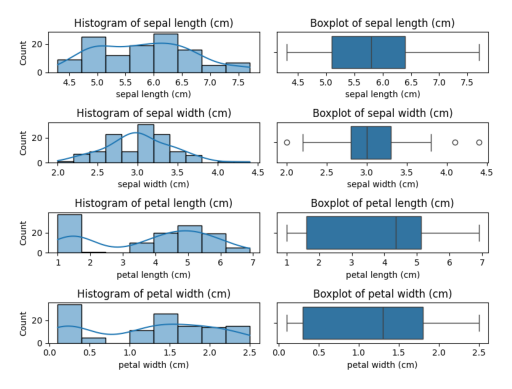

In [8]:
plt.imshow(plt.imread(f"figs/{DATASET_NAME}_feature-statistics-X_train.png"))
plt.axis("off")
plt.show()

We have some outliers for sepal width. 

*Decision Trees are generally considered robust to outliers so we will leave them.*

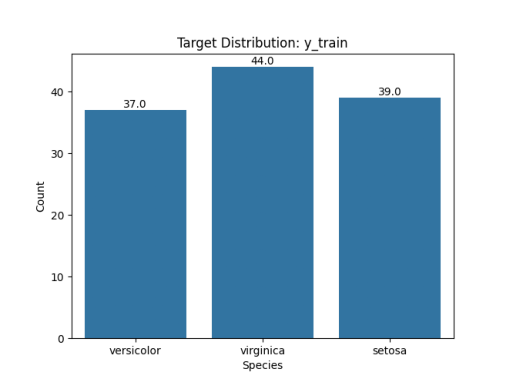

In [9]:
plt.imshow(plt.imread(f"figs/{DATASET_NAME}_target-class-distribution-y_train.png"))
plt.axis("off")
plt.show()

Classes in the train data are roughly balanced so we'll continue without any class balancing.

In [10]:
exp.update_param("n_train_samples", X_train.shape[0])
exp.update_param("n_test_samples", X_test.shape[0])
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-unpruned,iris-20test-shuffled-v1,120,30,1.0,entropy,0 days 00:00:00.005142,0 days 00:00:00.000668,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 13 0]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",5,9,NaN


So, we will use cross validation to evaluate the model so that we get a more generalizable result.

But how many folds?

## Find best cross-validation n_folds and type

NOTE: Learning curve already lets you see this!!! Don't need this extra step...just doing it for my own learning

How many folds should we use in our cross-validation? And what type of cross-validation should we use?

- Stratified K-Fold CV since we'd like to keep the class distribution in each fold similar to the original dataset

- Let's do a hypterparam search for number of folds

Recall, choice of k depends on computational resources, bias, variance, and the size of the dataset
- higher k
    + each model is trained on larger portion of the dataset (eg. k=10 => 90%) => lower bias, higher variance
    + more folds => more computational cost (more models to train and eval)
    + more "stable" estimates because the model is validated on more unique splits
- lower k
    + each model is trained on smaller portion of the dataset (eg. k=5 => 80%) => higher bias, lower variance
    + less folds => less computational cost (less models to train and eval)

SO....
- with smaller datasets like iris, we can afford to use higher k

**Note: if k = number of samples, then we have leave-one-out CV => low bias, high variance, high computational cost**

NOTE TO SELF: I CAN DO THIS WITH A LINE PLOT AND FILL BETWEEN FOR THE STD DEV

Range of k: range(2, 38)


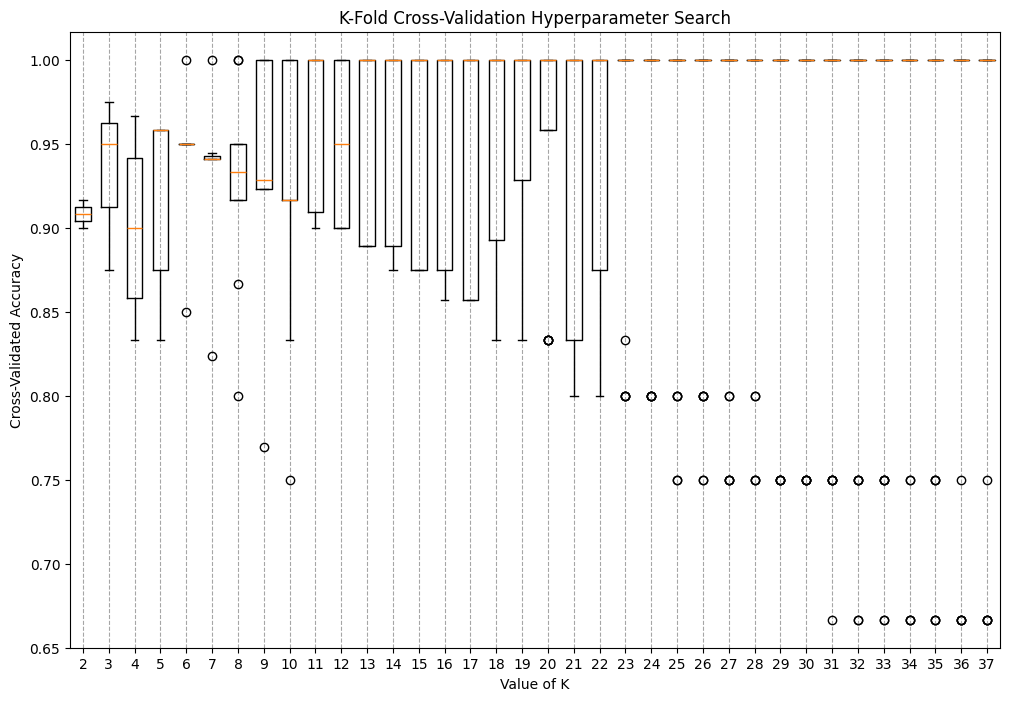

In [11]:
# Convert y_train to a 1-dimensional array
y_train_array = y_train.values.ravel()

# cross-validation hyperparameter search (cv-accuracy on Y axis and k on X axis)
min_class_samples = min(
    np.bincount(y_train_array)
)  # number of samples in the smallest class since StratifiedKFold requires each fold to have the same proportion of classes as the entire dataset

k_range = range(2, min_class_samples + 1)
k_scores = []
print(f"Range of k: {k_range}")

for k in k_range:  # for each value of k, run k-fold cross-validation
    scores = cross_val_score(
        exp.estimator,
        X_train,
        y_train_array,
        cv=StratifiedKFold(n_splits=k),
        scoring="accuracy",
    )
    k_scores.append(scores)

# Plotting the box plots
plt.figure(figsize=(12, 8))
plt.boxplot(k_scores, positions=k_range, widths=0.6)
plt.title("K-Fold Cross-Validation Hyperparameter Search")
plt.xlabel("Value of K")
plt.ylabel("Cross-Validated Accuracy")

# makes it easier to read the plot
plt.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

plt.savefig(f"{FIGS_DIR}/{exp.name}-kfold-cv.png")
plt.show()

So, 

- with 2 folds: in the first iteration 60 samples are trained on and 60 for testing. In the second iteration they get swapped and averaged for the final accuracy.

**Q: Why is CV accuracy lower with 12 folds?** Maybe just how the samples divide up since not perfectly even?


**Q: So with 10 folds there are 12 samples (120/10=12) in each fold so 108 train (9x12) and 12 test each of the 10 iterations?** Yes.

In [12]:
# disp_df of k and k_scores for the first 15 values of k
disp_df(pd.DataFrame(k_scores, index=k_range).T.head(15))

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,0.900000,0.975,0.966667,0.958333,0.95,0.944444,0.933333,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.000000
1,0.916667,0.950,0.833333,0.958333,1.00,1.000000,1.000000,0.928571,0.916667,0.909091,0.9,0.900000,0.888889,0.875,1.000000,1.000000,1.000000,0.857143,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.000000
2,NaN,0.875,0.933333,0.875000,0.95,0.941176,0.933333,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000,0.875000,0.857143,0.857143,1.000000,0.833333,0.833333,0.833333,0.833333,0.8,0.8,0.8,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,0.750000
3,NaN,NaN,0.866667,0.958333,0.95,0.941176,0.866667,0.923077,0.916667,0.909091,1.0,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.75,0.750000,1.000000
4,NaN,NaN,NaN,0.833333,0.95,0.941176,0.933333,1.000000,0.833333,1.000000,0.9,0.888889,0.888889,0.875,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,0.75,0.75,1.00,1.000000,1.000000
5,NaN,NaN,NaN,NaN,0.85,0.941176,1.000000,0.923077,0.916667,1.000000,0.9,1.000000,1.000000,1.000,1.000000,0.857143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.80,0.80,0.75,0.75,0.75,0.75,1.00,1.00,1.00,1.000000,1.000000
6,NaN,NaN,NaN,NaN,NaN,0.823529,0.933333,1.000000,1.000000,0.909091,1.0,1.000000,1.000000,1.000,1.000000,1.000000,0.857143,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,0.923077,1.000000,1.000000,0.9,0.888889,0.888889,1.000,1.000000,0.857143,1.000000,0.833333,0.833333,0.833333,0.833333,0.800000,0.8,0.8,0.8,0.80,0.80,0.75,0.75,1.00,1.00,1.00,1.00,1.00,1.000000,1.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.769231,0.916667,1.000000,1.0,1.000000,1.000000,0.875,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,0.75,1.00,1.00,1.00,1.00,1.000000,1.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.909091,0.9,1.000000,1.000000,1.000,0.857143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,0.75,1.00,1.00,1.00,1.000000,1.000000


Let's interpret this

Eg. if k=5 we are training 5 models on 80% of the data and validation on 20% and getting the score/accuracy
- training on 96 samples (120/5=24 samples per fold * 4)
- validating on 24 samples

- high values of k (20+) have high accuracy because they are being trained on so much of the training data but variance steadily increases
- lower values of k (5-) have lower accuracy because they are being trained on less of the training data but variance is lower also because 

In our case let's go with 3 since
- smaller variance and still relatively high accuracy

k=3 and 6 both give the same accuracy so

### Just for fun lets visualize the selected cv folds

In [13]:
k = 3
cv = StratifiedKFold(
    n_splits=k,
)

In [14]:
# print number of samples in each fold and samples per class
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    print(
        f"Fold {i} contains {len(train)} training samples and {len(test)} testing samples"
    )

    # bincount expects a 1-dimensional array
    y_train_array_train = y_train.iloc[train].to_numpy().flatten()
    y_train_array_test = y_train.iloc[test].to_numpy().flatten()

    print(
        f"Train: {np.bincount(y_train_array_train)}"
    )  # number of samples class 0, 1, 2
    print(f"Test: {np.bincount(y_train_array_test)}")  # number of samples class 0, 1, 2

Fold 0 contains 80 training samples and 40 testing samples
Train: [26 24 30]
Test: [13 13 14]
Fold 1 contains 80 training samples and 40 testing samples
Train: [26 25 29]
Test: [13 12 15]
Fold 2 contains 80 training samples and 40 testing samples
Train: [26 25 29]
Test: [13 12 15]


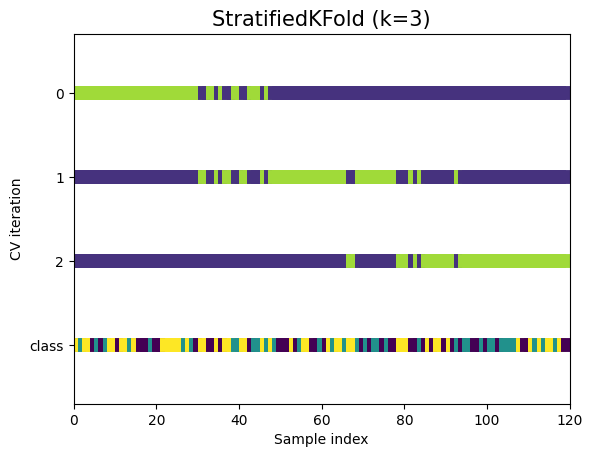

In [15]:
fig, ax = plt.subplots()
plot_cv_indices(
    cv=cv,
    X=X_train,
    y=y_train_array,
    ax=ax,
    n_splits=k,
)
fig.savefig(f"{FIGS_DIR}/{exp.name}-cv-indices.png")

## Inspect learning curve

Recall the LC shows us how the models performance changes with number of samples.

- required data size: how much data is needed for get good performance before improvement plateau

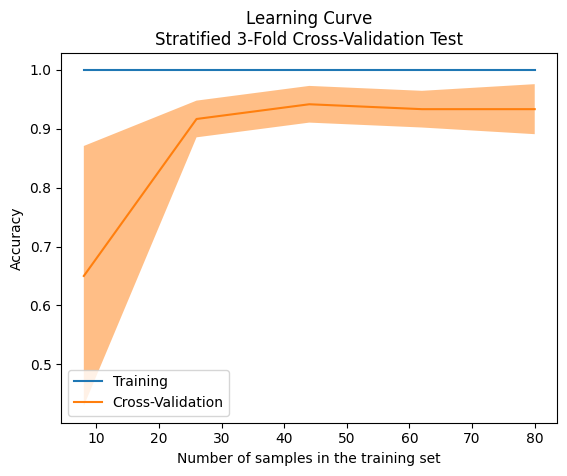

In [16]:
cv = StratifiedKFold(
    n_splits=3,
)
# Note: LearningCurveDisplay contains the scores as parameters (train_scores, test_scores)...could save these if needed
lcd = LearningCurveDisplay.from_estimator(
    estimator=exp.estimator,
    X=X_train,
    y=y_train,
    # train_sizes=np.linspace(0.1, 1.0, 5),
    # train_sizes=np.linspace(1, 80, 5).astype(int),
    train_sizes=np.linspace(0.1, 1.0, 5),
    # splitters are instantiated with shuffle=False so the splits will be the same across all calls
    cv=cv,
    random_state=0,
    # return_times = True, # default false
)

# Update the legend to change "Test" to "Cross-Validation"
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Training", "Cross-Validation"] if "Test" in labels else labels
plt.legend(handles, labels)

plt.title(f"Learning Curve\nStratified {cv.get_n_splits()}-Fold Cross-Validation Test")
plt.ylabel("Accuracy")
plt.savefig(f"{FIGS_DIR}/{exp.name}_learning-curve.png")

Interpretation:
- Train curve is perfect because DT can memorize the training data easily even when number of samples is small
- Around 20 samples is where the CV curve peaks

*Note: In simpler models, we often see a gradual improvement in training accuracy as the number of samples increases because they cannot memorize the training data perfectly. However, decision trees do not follow this pattern due to their high capacity to fit the training data exactly, even with a small number of samples.*

Conclusion:

- Keep training size the same since small model

In [17]:
exp.update_param("kfolds", f"Stratified {cv.get_n_splits()}-Fold Cross-Validation")

## Hyperparameter search

For this example we aren't going to search using gridsearch or anything....

We are just going to use criterion: entropy and max_depth: None (no pruning) since that is the experiment. We are expecting it to overfit.

In [18]:
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

In [19]:
params = {
    "classifier__criterion": "entropy",
    "classifier__max_depth": None,
    "classifier__max_features": None,
    "classifier__max_leaf_nodes": None,
}
exp.estimator.set_params(**params)
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

In [20]:
# fit on training data
start_time = pd.Timestamp.now()
exp.estimator.fit(X=X_train, y=y_train)
train_time = pd.Timestamp.now() - start_time

In [21]:
exp.update_param("train_time", train_time)
exp.update_param(
    "mean_accuracy",
    exp.estimator.score(X_test, y_test),
    # add_column=True
)
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-unpruned,iris-20test-shuffled-v1,120,30,0.966667,entropy,0 days 00:00:00.005195,0 days 00:00:00.000668,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 13 0]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",5,9,NaN


## Take a look at the trained model

In [22]:
text_representation = export_text(
    exp.estimator.named_steps["classifier"], feature_names=X_train.columns
)
print(text_representation)
with open(f"{RES_DIR}/{exp.name}-dtree.txt", "w") as f:
    f.write(text_representation)

|--- petal width (cm) <= -0.54
|   |--- class: 0
|--- petal width (cm) >  -0.54
|   |--- petal width (cm) <= 0.56
|   |   |--- petal length (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.65
|   |   |   |--- sepal length (cm) <= 0.26
|   |   |   |   |--- petal width (cm) <= 0.43
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  0.43
|   |   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  0.26
|   |   |   |   |--- class: 2
|   |--- petal width (cm) >  0.56
|   |   |--- petal length (cm) <= 0.59
|   |   |   |--- sepal width (cm) <= 0.19
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  0.19
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.59
|   |   |   |--- class: 2



In [23]:
# convert target names series to list
target_names_list = target_names["target_names"].tolist()
target_names_list

['setosa', 'versicolor', 'virginica']

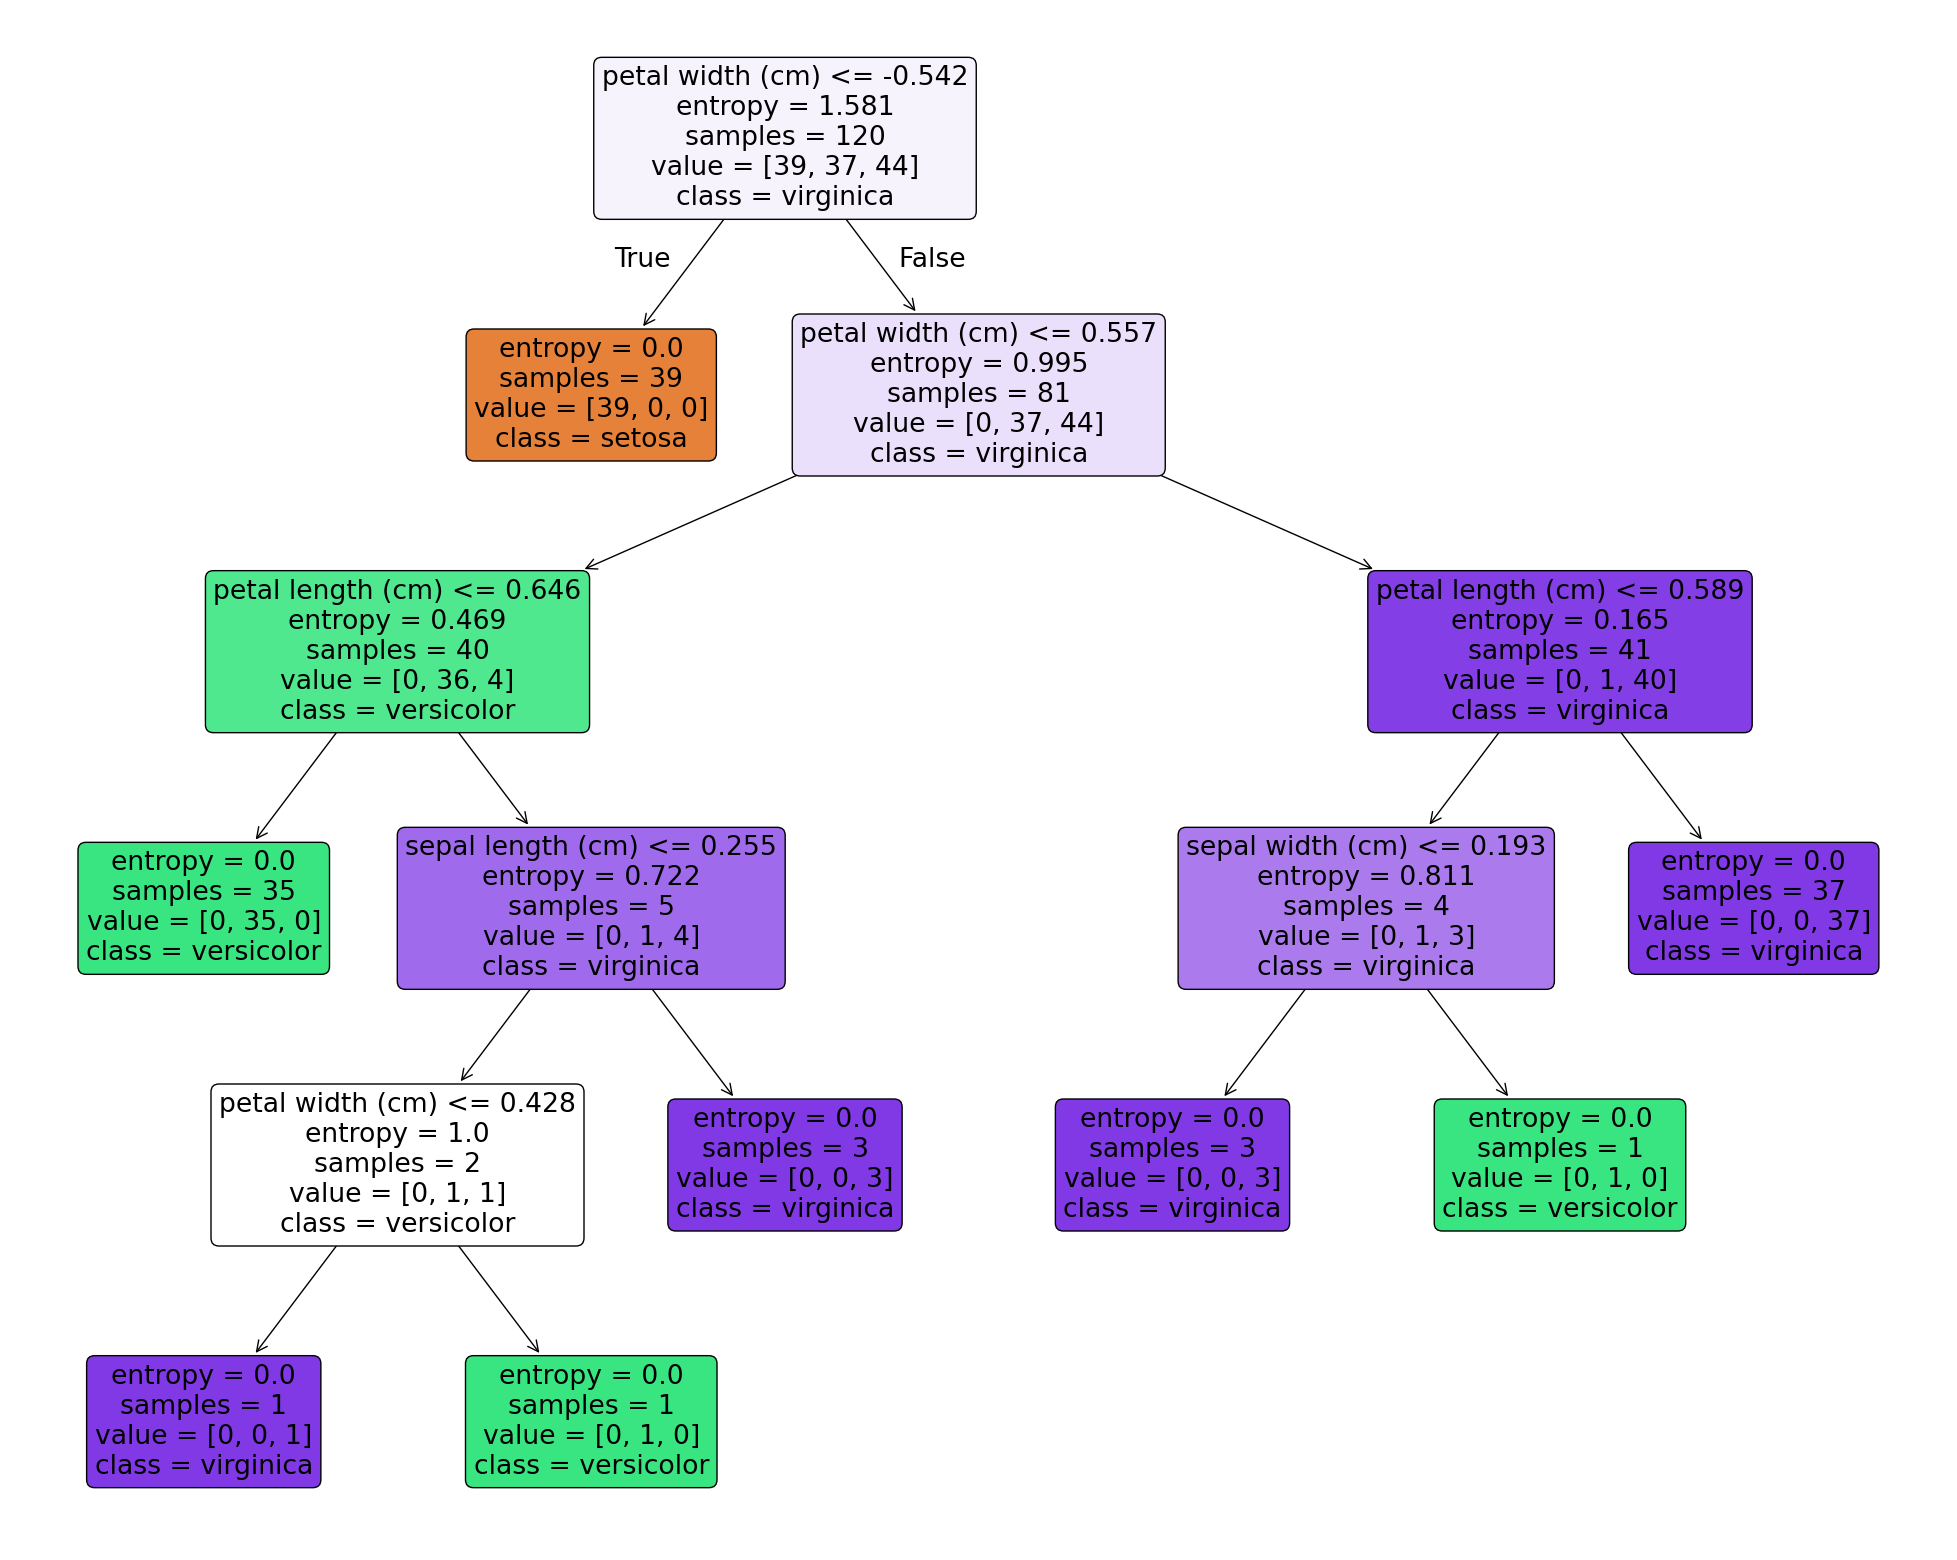

In [24]:
fig = plt.figure(figsize=(25, 20))
plot_tree(
    decision_tree=exp.estimator.named_steps["classifier"],
    feature_names=X_train.columns,
    class_names=target_names_list,
    filled=True,
    rounded=True,
)
plt.savefig(f"{FIGS_DIR}/{exp.name}_tree.png")

In [ ]:
# # can't figure out how to make DTviz work with a pipeline so this is a workaround but its shit cause it trains another model which is different...
# X_train_nparray = X_train.to_numpy()
# y_train_nparray = y_train.to_numpy().flatten()
# params = {
#     "criterion": "entropy",
#     "max_depth": None,
#     "max_features": None,
#     "max_leaf_nodes": None,
# }
# dtc_temp = DecisionTreeClassifier(**params)
# dtc_temp.fit(X_train, y_train)
# viz_model = dtreeviz.model(
#     dtc_temp,
#     X_train=X_train_nparray,
#     y_train=y_train_nparray,
#     target_name="iris",
#     feature_names=X_train.columns.to_list(),
#     class_names=target_names_list,
# )
# v = viz_model.view(scale=1.5)
# # v.save(f"{FIGS_DIR}/{exp.name}_dtreeviz.svg")
# v

In [25]:
# get precision, recall, f1, accuracy
start_time = pd.Timestamp.now()
y_pred = exp.estimator.predict(X_test)
query_time = pd.Timestamp.now() - start_time

In [26]:
exp.update_param("query_time", query_time)

Use a confusion matrix to see its classification performance...what it got wrong/right.

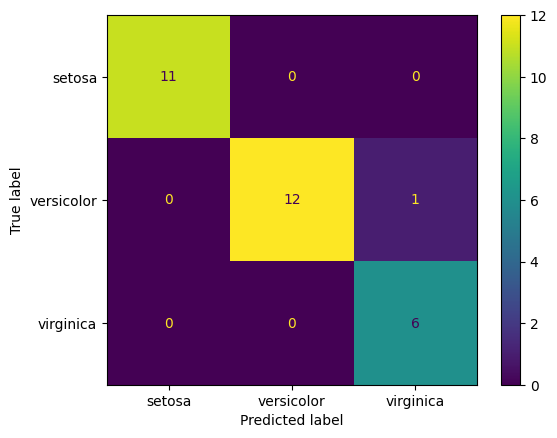

In [27]:
target_names_list = target_names["target_names"].tolist()
cm = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    # normalize="true"
)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_list)
cmd.plot()
plt.savefig(f"{FIGS_DIR}/{exp.name}_confusion-matrix.png")

**Q: I expected unpruned DT to classify everything correctly...why didn't it?** 

**Q: Did it overfit?** Train and test performance are pretty close so...no?

In [28]:
exp.update_param("confusion_matrix", np.array2string(cm))

In [29]:
cr = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True)
exp.update_param("classification_report", str(cr))
cr

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0},
 '1': {'precision': 1.0,
  'recall': 0.9230769230769231,
  'f1-score': 0.96,
  'support': 13.0},
 '2': {'precision': 0.8571428571428571,
  'recall': 1.0,
  'f1-score': 0.9230769230769231,
  'support': 6.0},
 'accuracy': 0.9666666666666667,
 'macro avg': {'precision': 0.9523809523809524,
  'recall': 0.9743589743589745,
  'f1-score': 0.9610256410256411,
  'support': 30.0},
 'weighted avg': {'precision': 0.9714285714285714,
  'recall': 0.9666666666666667,
  'f1-score': 0.9672820512820512,
  'support': 30.0}}

In [30]:
# add custom decision tree classification specific metrics to the summary_df
exp.update_param(
    "split_criterion",
    exp.estimator.named_steps["classifier"].criterion,
    add_column=True,
)
exp.update_param(
    "tree_depth", exp.estimator.named_steps["classifier"].get_depth(), add_column=True
)
exp.update_param(
    "n_leaves", exp.estimator.named_steps["classifier"].get_n_leaves(), add_column=True
)
exp.update_param(
    "n_tree_nodes",
    exp.estimator.named_steps["classifier"].tree_.node_count,
    add_column=True,
)
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,split_criterion,train_time,query_time,kfolds,confusion_matrix,classification_report,tree_depth,n_leaves,n_tree_nodes
exp_name,,,,,,,,,,,,,
dtc-iris-unpruned,iris-20test-shuffled-v1,120,30,0.966667,entropy,0 days 00:00:00.005195,0 days 00:00:00.000654,Stratified 3-Fold Cross-Validation,[[11 0 0]\n [ 0 12 1]\n [ 0 0 6]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",5,8,15.0


In [ ]:
# exp.save(overwrite_existing=False)

## Conclusions

- Expectation: it will overfit the training data (high variance)
    - Yes, it overfit the training data

- training time will be minimal since the dataset is small
    + Yes, training time was minimal